<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_6_4_Keras_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install DEAP
!pip install deap --quiet
!pip install livelossplot --quiet

In [ ]:
#@title Imports
import tensorflow as tf
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
from IPython.display import clear_output
from livelossplot import PlotLossesKeras

#DEAP
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import random

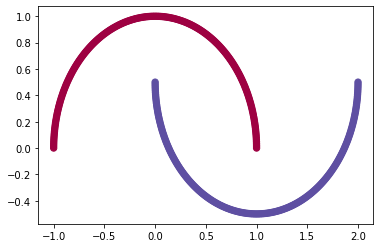

In [ ]:
#@title Dataset Parameters  { run: "auto" }
number_samples = 400 #@param {type:"slider", min:100, max:1000, step:25}
difficulty = 1 #@param {type:"slider", min:1, max:5, step:1}
problem = "moons" #@param ["classification", "blobs", "gaussian quantiles", "moons", "circles"]
number_features = 2
number_classes = 2 
middle_layer = 25 #@param {type:"slider", min:5, max:25, step:1}
epochs = 50 #@param {type:"slider", min:5, max:50, step:1}

def load_data(problem):  
  if problem == "classification":
    clusters = 1 if difficulty < 3 else 2
    informs = 1 if difficulty < 4 else 2
    data = sklearn.datasets.make_classification(
        n_samples = number_samples,
        n_features=number_features, 
        n_redundant=0, 
        class_sep=1/difficulty,
        n_informative=informs, 
        n_clusters_per_class=clusters)
    
  if problem == "blobs":
    data = sklearn.datasets.make_blobs(
        n_samples = number_samples,
        n_features=number_features, 
        centers=number_classes,
        cluster_std = difficulty)
  
  if problem == "gaussian quantiles":
    data = sklearn.datasets.make_gaussian_quantiles(mean=None, 
                                                  cov=difficulty,
                                                  n_samples=number_samples,
                                                  n_features=number_features,
                                                  n_classes=number_classes,
                                                  shuffle=True,
                                                  random_state=None)
    
  if problem == "moons":
    data = sklearn.datasets.make_moons(
        n_samples = number_samples)
    
  if problem == "circles":
    data = sklearn.datasets.make_circles(
        n_samples = number_samples)
    
  return data

data = load_data(problem)
X, Y = data

# Input Data
plt.figure("Input Data")
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)


In [ ]:
#@title Helper function to show prediction results
def show_predictions(model, X, Y, name=""):
    """ display the labeled data X and a surface of prediction of model """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    X_temp = np.c_[xx.flatten(), yy.flatten()]
    Z = model.predict(X_temp)
    plt.figure("Predictions " + name)
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1],c=Y, s=40, cmap=plt.cm.Spectral)    

Logistic Regression accuracy :  0.89


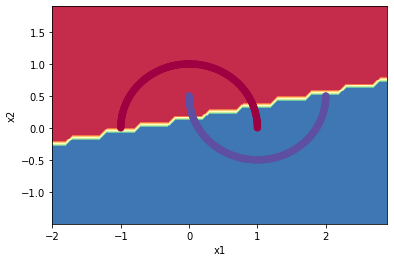

In [ ]:
#@title Logisitc Regression with SKLearn
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, Y)

show_predictions(clf, X, Y, "Logistic regression")
    
LR_predictions = clf.predict(X)
print("Logistic Regression accuracy : ", np.sum(LR_predictions == Y) / Y.shape[0])

In [ ]:
#@title Setup Keras Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(16, activation='relu', input_shape=(X.shape[1],)),  
  tf.keras.layers.Dense(32, activation='relu'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
print(f"Trainable parameters: {trainableParams}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Trainable parameters: 625


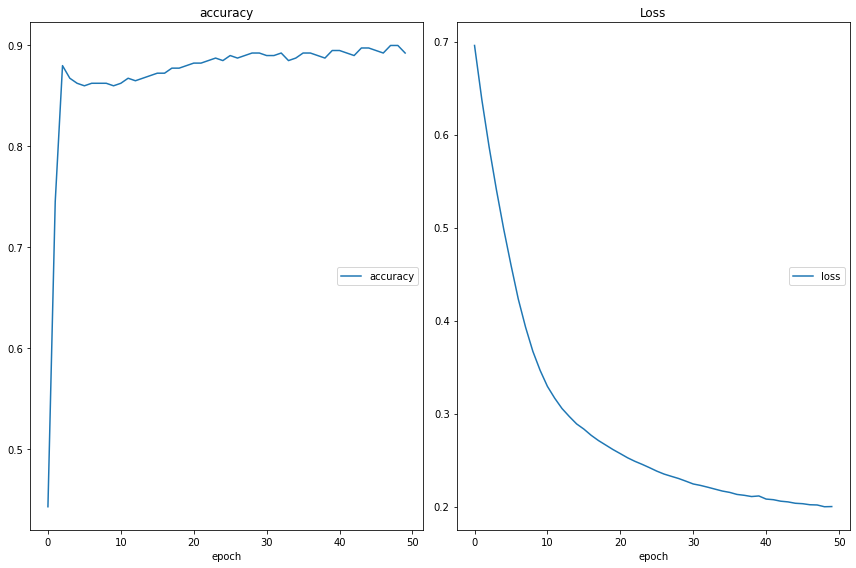

accuracy
	accuracy         	 (min:    0.442, max:    0.900, cur:    0.892)
Loss
	loss             	 (min:    0.200, max:    0.696, cur:    0.200)


In [ ]:
model.fit(X, Y, epochs=epochs,
          callbacks=[PlotLossesKeras()],
          verbose=0)

In [ ]:
model.evaluate(X,Y)

13/13 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.8950


[0.1984635591506958, 0.8949999809265137]

13/13 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.8950
Neural Network accuracy :  0.8949999809265137


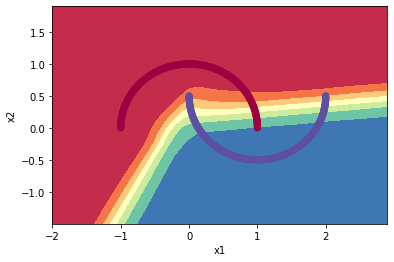

In [ ]:
show_predictions(model, X, Y, "Keras with Adam")
print("Neural Network accuracy : ", model.evaluate(X,Y)[1])

In [ ]:
def print_parameters():
  for layer in model.layers:
    for na in layer.get_weights():
      print(na)

def set_parameters(individual):
  idx = 0
  tensors=[]
  for layer in model.layers:
    for na in layer.get_weights():
      size = na.size
      sh = na.shape
      t = individual[idx:idx+size]
      t = np.array(t)
      t = np.reshape(t, sh)      
      idx += size
      tensors.append(t)
  model.set_weights(tensors)

In [ ]:
number_of_genes = trainableParams
print(number_of_genes)

individual = np.ones(number_of_genes)
set_parameters(individual)

print("Neural Network accuracy : ", model.evaluate(X,Y)[1])
print_parameters()

625
13/13 [==============================] - 0s 1ms/step - loss: 434.6564 - accuracy: 0.5000
Neural Network accuracy :  0.5
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.

13/13 [==============================] - 0s 2ms/step - loss: 434.6564 - accuracy: 0.5000
Neural Network accuracy :  0.5


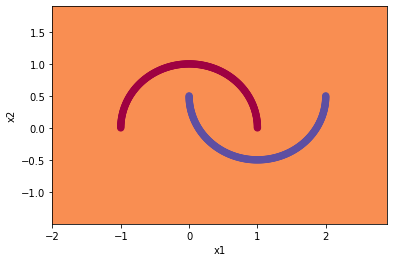

In [ ]:
show_predictions(model, X, Y, "Neural Network")
print("Neural Network accuracy : ", model.evaluate(X,Y)[1])

In [ ]:
#@title Setting up the Creator
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [ ]:
#@title Create Individual and Population
def uniform(low, up, size=None):
  try:
    return [random.uniform(a, b) for a, b in zip(low, up)]
  except TypeError:
    return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, -1, 1, number_of_genes)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selTournament, tournsize=5)

In [ ]:
toolbox.register("mate", tools.cxBlend, alpha=.5)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=.1, indpb=.25)

In [ ]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

def evaluate(individual):  
  set_parameters(individual)
  print('.', end='')
  return 1/clamp(model.evaluate(X,Y, verbose=0)[1], .00001, 1), 

toolbox.register("evaluate", evaluate)   

In [ ]:
#@title Optimize the Weights { run: "auto" }
MU = 35 #@param {type:"slider", min:5, max:1000, step:5}
NGEN = 100 #@param {type:"slider", min:100, max:1000, step:10}
RGEN = 1 #@param {type:"slider", min:1, max:100, step:1}
CXPB = .6
MUTPB = .3

random.seed(64)

pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

Gen (18)
13/13 [==============================] - 0s 2ms/step - loss: 0.2896 - accuracy: 0.9525
Neural Network accuracy :  0.9524999856948853


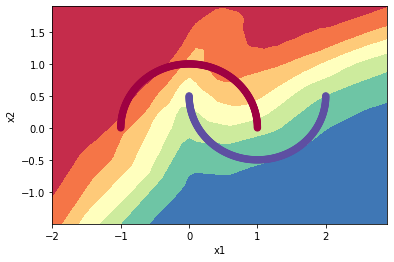

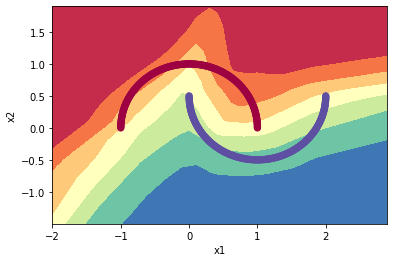

13/13 [==============================] - 0s 2ms/step - loss: 0.3398 - accuracy: 0.9900
Best neural Network accuracy :  0.9900000095367432


In [ ]:
best = None
history = []

for g in range(NGEN):
  pop, logbook = algorithms.eaSimple(pop, toolbox, 
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)
  best = hof[0] 
  clear_output()
  print(f"Gen ({(g+1)*RGEN})")
  show_predictions(model, X, Y, "Neural Network") 
  print("Neural Network accuracy : ", model.evaluate(X,Y)[1])
  plt.show()

  set_parameters(best)
  show_predictions(model, X, Y, "Best Neural Network")
  plt.show()  
  acc = model.evaluate(X,Y)[1]
  print("Best neural Network accuracy : ", acc)
  if acc > .99: #stop condition
    break